In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### The original code is provided below, followed by my solution

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [6]:
for p in parameters:
  p.requires_grad = True

In [7]:
lri = []
lossi = []
stepi = []

In [8]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [9]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1512, grad_fn=<NllLossBackward0>)

In [10]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1888, grad_fn=<NllLossBackward0>)

### E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
I've decided to increase the context window and the number of iterations while adjusting the learning rate

In [13]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 4]) torch.Size([182437])
torch.Size([22781, 4]) torch.Size([22781])
torch.Size([22928, 4]) torch.Size([22928])


In [16]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_size = 10
hidden_layer_dim = 200
stoi_len = len(stoi)
ema_alpha = 0.05
C = torch.randn((stoi_len, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_dim), generator=g)
b1 = torch.randn(hidden_layer_dim, generator=g)
W2 = torch.randn((hidden_layer_dim, stoi_len), generator=g)
b2 = torch.randn(stoi_len, generator=g)
parameters = [C, W1, b1, W2, b2]

In [17]:
for p in parameters:
  p.requires_grad = True
lossi = []
stepi = []
cur_i = 0

In [ ]:
for _ in range(1_000_000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  if cur_i < 200_000:
      lr = 0.1
  elif cur_i < 400_000:
      lr = 0.01
  else:
      lr = 0.001 * 400_000 / cur_i
  for p in parameters:
    p.data += -lr * p.grad

  if cur_i % 2000 == 0 and cur_i >= 1000:
      if not len(lossi):
          lossi.append(loss.item())
      else:
          ema_loss = (1 - ema_alpha) * lossi[len(lossi) - 1] + ema_alpha * loss.item()
          lossi.append(ema_loss)
          print(f'iteration - {cur_i}, loss - {ema_loss}')
      stepi.append(cur_i)
  cur_i += 1

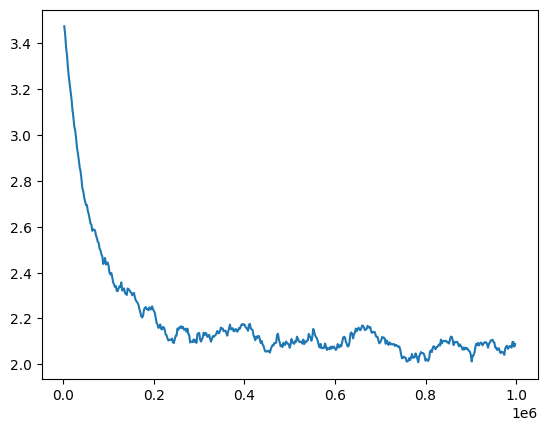

In [19]:
share = int(len(stepi))
plt.plot(stepi[-share:], lossi[-share:])

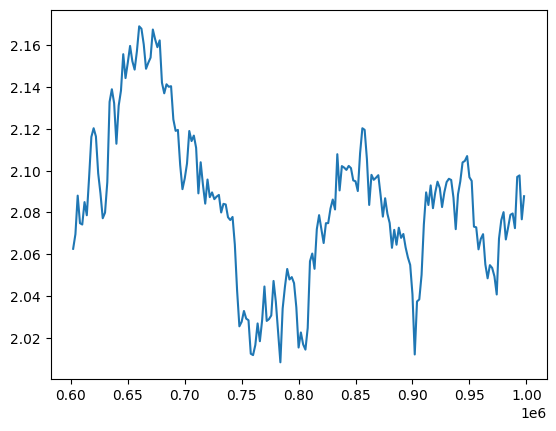

In [22]:
share = int(len(stepi) * 0.4)
plt.plot(stepi[-share:], lossi[-share:])

### My score

In [23]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0677, grad_fn=<NllLossBackward0>)

In [24]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1408, grad_fn=<NllLossBackward0>)

### E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [17]:
# Since the distribution is uniform, all probabilities are equal and therefore the loss has the following form
# where n is the number of possible answers
n = 27
-torch.log(torch.tensor(1/n))

tensor(3.2958)

In [35]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_size = 10
hidden_layer_dim = 200
stoi_len = len(stoi)
ema_alpha = 0.05
C = torch.randn((stoi_len, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_dim), generator=g)
b1 = torch.zeros(hidden_layer_dim)
W2 = torch.randn((hidden_layer_dim, stoi_len), generator=g)
b2 = torch.zeros(stoi_len)
parameters = [C, W1, b1, W2, b2]

In [36]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(24.7028)

In [ ]:
# Our initial loss reaches about 20, as there is a preponderance of some classes due to incorrect initialization

In [39]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_size = 10
hidden_layer_dim = 200
stoi_len = len(stoi)
ema_alpha = 0.05
std = 0.1
C = torch.randn((stoi_len, embedding_size), generator=g) * std
W1 = torch.randn((block_size * embedding_size, hidden_layer_dim), generator=g) * std
b1 = torch.zeros(hidden_layer_dim)
W2 = torch.randn((hidden_layer_dim, stoi_len), generator=g) * std
b2 = torch.zeros(stoi_len)
parameters = [C, W1, b1, W2, b2]

In [40]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.2994)